In [1]:
import os
from timeit import default_timer as timer
from datetime import datetime, timedelta, date
from glob import glob
from pathlib import Path
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

/share/apps/anaconda3/2019.10/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def get_coords(df):
    df['latitude']=df['point'].apply(lambda x:x['latitude'])
    df['longitude']=df['point'].apply(lambda x:x['longitude'])
    return df.drop('point',1)

# 0 = Monday, 1=Tuesday, 2=Wednesday...
def next_weekday(d, weekday):
    days_ahead = weekday - d.weekday()
    if days_ahead <= 0: # Target day already happened this week
        days_ahead += 7
    return d + timedelta(days_ahead)

In [3]:
path_to_data='/scratch/spf248/covid/data'
start_date='01/01/2020'
end_date='04/16/2020'
source='cuebiq'
country='ID'
admin_id='ADM4_PCODE'
admin_agg='ADM3_PCODE'
city_id='UC_NM_MN'
city_name='Jakarta'
freq='SMS'
final_date=date(datetime.today().year, datetime.today().month,1)
initial_date=date(datetime.today().year, datetime.today().month-2,1)

# Import Data

In [4]:
print('Import admin data')
start = timer()
admin = gpd.read_file(os.path.join(path_to_data,'admin',country,'admin.geojson'))
admin2city=pd.read_excel(os.path.join(path_to_data,'admin',country,'city2adminGHSL.xlsx'))[[city_id,admin_id]].drop_duplicates(admin_id)
print("Done in", round(timer()-start), "sec")  

Import admin data
Done in 64 sec


In [5]:
print('Import home locations')
start = timer()
data_dir = Path(os.path.join(path_to_data,source,'processed',country,'primary_home'))
primary_home = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('*.parquet')
)
print("Done in", round(timer()-start), "sec")  

Import home locations
Done in 7 sec


In [6]:
print('Import geocoded pings')
start = timer()
data_dirs=glob(os.path.join(path_to_data,source,'processed',country,'pings_geocoded','*'))
pings_geocoded=pd.concat(
    pd.read_parquet(parquet_file)
    for data_dir in data_dirs for parquet_file in Path(data_dir).glob('*.parquet')
)
print("Done in", round(timer()-start), "sec")

Import geocoded pings
Done in 136 sec


# Data processing

In [7]:
print('Process')
start = timer()
primary_home=get_coords(primary_home)
print("Done in", round(timer()-start), "sec")  

Process
Done in 0 sec


In [8]:
print('Process')
start = timer()
pings_geocoded['date']=pd.to_datetime(pings_geocoded.time.dt.date)
pings_geocoded.reset_index(drop=True,inplace=True)
print("Done in", round(timer()-start), "sec")  

Process
Done in 91 sec


In [9]:
print('Home Pings')
start = timer()
pings_home=pings_geocoded[pings_geocoded['classification_type']=='PERSONAL_AREA'].merge(
primary_home.drop('perfect_match',1),on=['cuebiq_id','latitude','longitude'],right_index=True)
print("Done in", round(timer()-start), "sec")  

Home Pings
Done in 128 sec


In [10]:
print('Count Pings Outside of Home')
start = timer()
n_pings_non_home=pings_geocoded.drop(pings_home.index).groupby(['date',admin_id],as_index=False)['time'].count()
print("Done in", round(timer()-start), "sec")  

Count Pings Outside of Home
Done in 48 sec


In [11]:
print('Aggregation')
start = timer()
n_pings_non_home=n_pings_non_home[
(n_pings_non_home.date>=pd.to_datetime(start_date))&\
(n_pings_non_home.date<pd.to_datetime(end_date))].copy()
n_pings_non_home=n_pings_non_home.merge(admin[[admin_id,admin_agg]]).groupby(
[pd.Grouper(key='date', freq=freq),admin_agg])['time'].sum().rename('n_pings')
print("Done in", round(timer()-start), "sec")  

Aggregation
Done in 9 sec


In [12]:
print('Activity Change')
start = timer()
n_pings_non_home=n_pings_non_home.xs(final_date,level='date').rename('pings_final').reset_index().merge(
n_pings_non_home.xs(initial_date,level='date').rename('pings_initial').reset_index())
n_pings_non_home['pct_change']=(n_pings_non_home.pings_final.divide(n_pings_non_home.pings_initial)-1)*100
print("Done in", round(timer()-start), "sec")  

Activity Change
Done in 0 sec


In [13]:
print('Select City-level Activity')
start = timer()
admin_city=admin[[admin_agg,admin_id,'geometry']].merge(
admin2city[admin2city[city_id]==city_name]).dissolve(
admin_agg,as_index=False)[[admin_agg,'geometry']]
n_pings_non_home=admin_city.merge(n_pings_non_home).drop(admin_agg,1)
print("Done in", round(timer()-start), "sec")  

Select City-level Activity
Done in 15 sec


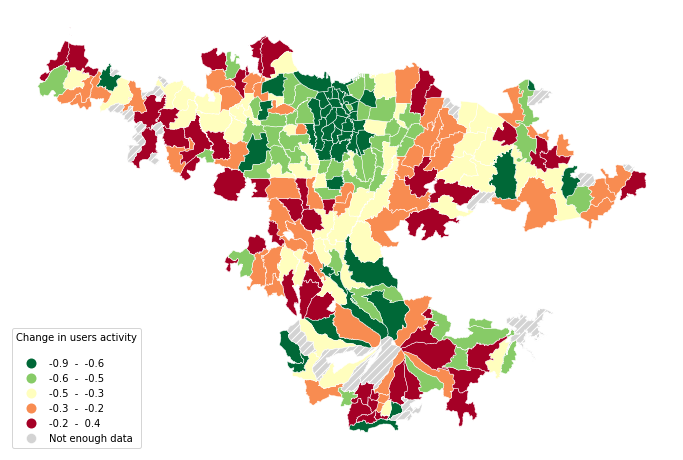

In [93]:
fig, ax = plt.subplots(1, figsize=(12, 12))

df=n_pings_non_home.copy()
df.loc[df.pings_initial<1500,'pct_change']=np.nan
plot = df.plot(
ax=ax,
column='pct_change', 
edgecolor='white', 
linewidth=0.5,
legend=True, 
cmap='RdYlGn_r', 
scheme='quantiles',
missing_kwds={"color": "lightgrey","hatch": "///","label": "Not enough data",},
legend_kwds={'loc': 'lower left','title':'Change in users activity\n'})
ax.axis('off')

leg = plot.get_legend()
for lbl in leg.get_texts()[:-1]:
    label_text = lbl.get_text()
    lower = label_text.split()[0]
    upper = label_text.split()[2]
    new_text = f'{float(lower):,.1f}  -  {float(upper):,.1f}'
    lbl.set_text(new_text)


plt.savefig(os.path.join(path_to_data,'../fig/activity-change-'+city_name+'.pdf'), bbox_inches='tight')